In [1]:
import celltypist
import scanpy as sc
import numpy as np
import pandas as pd
import scvi
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt

The first approach for aligning the in vivo and in vitro trophoblast cells was using CellTypist to train a logistic regression classifier based on the in vivo trophoblast from Arutyunyan et al., Nature 2023. The resulting model was used to predict the identities of the in vitro cells.

🍳 Preparing data before training
✂️ 6 non-expressed genes are filtered out
⚖️ Scaling input data
🏋️ Training data using logistic regression
✅ Model training done!
🔬 Input data has 67996 cells and 23049 genes
🔗 Matching reference genes in the model
🧬 1893 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


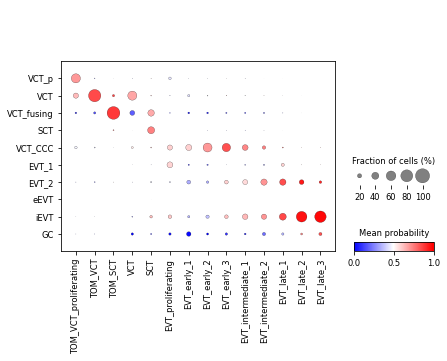

In [2]:
##in vivo cells from Arutyunyan et al., Nature 2023
adata1 = sc.read('../../../adata_P13_trophoblast_raw_counts_in_raw_normlog_counts_in_X_for_download.h5ad')
adata1.obs['celltype'] = adata1.obs['final_annot_all_troph_corrected'].astype(str)

##in vitro cells from organoids. Here all the cells (including low-quality cells) were loaded to use the 2000 highly
##variable genes for running CellTypist. Only high-quality cells were considered for this analysis.
adata2 = sc.read('../../../scvi/HVG_2000_latent_10_res_all.h5ad')
ggs = adata2.var_names
adata2 = adata2.raw.to_adata()
new_nms = [
        'EVT_late_1', 'EVT_early_1', 'EVT_proliferating', 'EVT_early_lowUMI_1', 'EVT_late_2', 'SCT', 'TOM_VCT',
        'EVT_early_3', 'EVT_intermediate_2', 'TOM_VCT_proliferating', 'EVT_intermediate_1', 'SCT_lowUMI',
        'EVT_intermediate_lowUMI', 'VCT', 'EVT_early_lowUMI_2', 'EVT_late_lowUMI', 'VCT_lowUMI', 'EVT_early_2',
        'EVT_late_3', 'TOM_SCT']
adata2.rename_categories('leiden', new_nms)
adata2.obs['celltype'] = adata2.obs['leiden'].astype(str)
ind = (~adata2.obs['celltype'].str.contains('lowUMI')) & (adata2.obs['ID'] != 'ID4')
adata2 = adata2[ind, :]

##select genes. The intersection of genes expressed in the in vivo dataset with the highly variable genes
##from the in vitro dataset were used for the model training.
ggs = adata1.var_names.intersection(ggs)
adata1 = adata1[:, ggs]

##run CellTypist
#training
model = celltypist.train(adata1, 'celltype', n_jobs = -1, check_expression=False, feature_selection=False)
#prediction
predictions = celltypist.annotate(adata2, model = model)
#visualization
xx_ctys = ['TOM_VCT_proliferating', 'TOM_VCT', 'TOM_SCT',
           'VCT', 'SCT',
           'EVT_proliferating', 'EVT_early_1', 'EVT_early_2', 'EVT_early_3',
           'EVT_intermediate_1', 'EVT_intermediate_2',
           'EVT_late_1', 'EVT_late_2', 'EVT_late_3']
yy_ctys = ['VCT_p', 'VCT',
           'VCT_fusing', 'SCT',
           'VCT_CCC', 'EVT_1', 'EVT_2', 'eEVT', 'iEVT', 'GC']
celltypist.dotplot(predictions, 'celltype', 'predicted_labels', prediction_order=yy_ctys, reference_order=xx_ctys, cmap='bwr', title='')

The second approach to align in vivo and in vitro trophoblast cells was to compare each in vitro cell with each in vivo subtype based on their transcriptomic similarity. Each in vitro cell was assigned to the in vivo subtype with the highest Pearson correlation coefficient. The in vivo cells for this comparison were from Vento-Tormo et al., Nature 2018.

In [7]:
##in vivo data from Vento-Tormo et al., Nature 2018
adata1 = sc.read('../../../Roser_old_data.h5ad')
sc.pp.filter_genes(adata1, min_cells=20)
sc.pp.normalize_total(adata1, target_sum=1e4)
sc.pp.log1p(adata1)
ind = np.isin(adata1.obs['annotation'], ['VCT', 'EVT', 'SCT'])
adata1 = adata1[ind, :].copy()
adata1.obs['celltype'] = adata1.obs['annotation'].astype(str)
adata1.obs.loc[((adata1.obs['location']=='Decidua').values & (adata1.obs['celltype']=='EVT').values), 'celltype'] = 'dEVT'
adata1.obs.loc[((adata1.obs['location']=='Placenta').values & (adata1.obs['celltype']=='EVT').values), 'celltype'] = 'pEVT'

##in vitro data from organoids
adata2 = sc.read('../../../scvi/HVG_2000_latent_10_res.h5ad')
new_nms = [
        'EVT_late_1', 'EVT_early_1', 'EVT_proliferating', 'EVT_early_lowUMI_1', 'EVT_late_2', 'SCT', 'TOM_VCT',
        'EVT_early_3', 'EVT_intermediate_2', 'TOM_VCT_proliferating', 'EVT_intermediate_1', 'SCT_lowUMI',
        'EVT_intermediate_lowUMI', 'VCT', 'EVT_early_lowUMI_2', 'EVT_late_lowUMI', 'VCT_lowUMI', 'EVT_early_2',
        'EVT_late_3', 'TOM_SCT']
adata2.rename_categories('leiden', new_nms)
adata2.obs['celltype'] = adata2.obs['leiden'].copy()
ind = ((~adata2.obs['celltype'].str.contains('lowUMI')) & (adata2.obs['ID'] != 'ID4'))
adata2 = adata2[ind, :]

##select genes that are highly variable in the in vitro dataset and meanwhile expressed in the in vivo dataset
ggs = adata1.var_names.intersection(adata2.var_names)
adata1 = adata1[:, ggs].copy()
adata2 = adata2[:, ggs].copy()

##for each in vivo cell type, calculate the average expression
mat1 = [np.log1p(np.expm1(adata1.X)[(adata1.obs['celltype']==i).values, :].mean(0)) for i in ['VCT', 'SCT', 'pEVT', 'dEVT']]
mat1 = np.row_stack(mat1)

##calculate the Pearson correlation coefficient between each in vitro cell and each in vivo cell type
mat2 = adata2.X.A
dd = pairwise_distances(mat2, mat1, metric='correlation')

##assign each in vitro cell to the most similar in vivo cell type (with the highest coefficient)
idx = dd.argmin(1)
tb = pd.crosstab(adata2.obs['celltype'], idx)
tb = tb/tb.sum(1)[:, None]
tb.columns = ['placenta_VCT', 'placenta_SCT', 'placenta_EVT', 'decidua_EVT']

##sankey plot
ctys1 = ['TOM_VCT_proliferating', 'TOM_VCT', 'VCT', 'TOM_SCT', 'SCT', 'EVT_proliferating', 'EVT_early_1',
         'EVT_early_2', 'EVT_early_3', 'EVT_intermediate_1', 'EVT_intermediate_2', 'EVT_late_1', 'EVT_late_2',
         'EVT_late_3']
ctys2 = ['placenta_VCT', 'placenta_SCT', 'placenta_EVT', 'decidua_EVT']
col1 = ['#b5cf6b', '#74c476', '#31a354', '#fd8d3c', '#e6550d', '#17becf', '#c7e9c0', '#aec7e8', '#9edae5',
        '#1d91c0', '#4a6fe3', '#6b6ecf', '#023fa5', '#0000ff']
col2 = ['#f781bf', '#ffff33', '#984ea3', '#e41a1c']
labels = ctys1 + ctys2
cols = col1 + col2
sources = np.repeat(np.arange(len(ctys1)), len(ctys2))
targets = np.tile(np.arange(len(ctys2)), len(ctys1)) + len(ctys1)
values = tb.loc[ctys1, ctys2].values.flatten()
values[values < 0.07] = 0
fig = go.Figure(data=[go.Sankey(
    node = dict(
        label = labels,
        color = cols,
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values,
    )
)])
fig.write_html('EVT_invivo_invitro_align_sankey_plot.html')

In [8]:
tb

,VCT,SCT,placenta_EVT,decidua_EVT
celltype,,,,
EVT_late_1,0.000000,0.000756,0.721088,0.278156
EVT_early_1,0.119456,0.026953,0.851367,0.002224
EVT_proliferating,0.087665,0.001493,0.909893,0.000950
EVT_late_2,0.000000,0.000000,0.210472,0.789528
SCT,0.000180,0.933129,0.043619,0.023071
TOM_VCT,0.936005,0.063586,0.000409,0.000000
EVT_early_3,0.006506,0.249628,0.645725,0.098141
EVT_intermediate_2,0.000000,0.022923,0.875358,0.101719
TOM_VCT_proliferating,0.991021,0.008270,0.000709,0.000000


The third approach to align the in vivo and in vitro EVT cells was to integrate them using scVI. The in vivo cells used here were from Vento-Tormo et al., Nature 2018.

In [2]:
##in vitro EVT cells from organoids
adata1 = sc.read('../../../ogn_raw_counts_all_cells.h5ad')
new_nms = [
        'EVT_late_1', 'EVT_early_1', 'EVT_proliferating', 'EVT_early_lowUMI_1', 'EVT_late_2', 'SCT', 'TOM_VCT',
        'EVT_early_3', 'EVT_intermediate_2', 'TOM_VCT_proliferating', 'EVT_intermediate_1', 'SCT_lowUMI',
        'EVT_intermediate_lowUMI', 'VCT', 'EVT_early_lowUMI_2', 'EVT_late_lowUMI', 'VCT_lowUMI', 'EVT_early_2',
        'EVT_late_3', 'TOM_SCT']
adata1.rename_categories('leiden', new_nms)
adata1.obs['celltype'] = adata1.obs['leiden'].copy()
sc.pp.filter_genes(adata1, min_cells=10)
ind = adata1.obs['celltype'].str.contains('EVT') & (~adata1.obs['celltype'].str.contains('lowUMI')) & (adata1.obs['ID']!='ID4')
adata1 = adata1[ind, :].copy()
adata1.obs['source'] = 'in_vitro'

##in vivo EVT cells from Vento-Tormo et al., Nature 2018
adata2 = sc.read('../../../Roser_old_data.h5ad')
adata2.obs['celltype'] = adata2.obs['annotation'].copy()
adata2.obs.loc[((adata2.obs['annotation']=='EVT').values & (adata2.obs['location']=='Decidua').values), 'celltype'] = 'decidua_EVT'
adata2.obs.loc[((adata2.obs['annotation']=='EVT').values & (adata2.obs['location']=='Placenta').values), 'celltype'] = 'placenta_EVT'
adata2.obs['ID'] = adata2.obs['Fetus'].copy()
sc.pp.filter_genes(adata2, min_cells=10)
ind = (adata2.obs['celltype'] == 'EVT') & np.isin(adata2.obs['ID'], ['D9', 'D10', 'D11', 'D12'])
adata2 = adata2[ind, :].copy()
adata2.obs['source'] = 'in_vivo'

##select highly variable genes
adata = adata1.concatenate(adata2)
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, layer='counts', n_top_genes=1000, flavor='seurat_v3', batch_key='ID', subset=True)

##run scVI
scvi.data.setup_anndata(adata, layer="counts", batch_key="ID")
vae = scvi.model.SCVI(adata, n_latent=10)
vae.train()
adata.obsm["X_scVI"] = vae.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)
sc.tl.leiden(adata)

INFO     Using batches from adata.obs["ID"]                                                  


Using batches from adata.obs["ID"]


INFO     No label_key inputted, assuming all cells have same label                           


No label_key inputted, assuming all cells have same label


INFO     Using data from adata.layers["counts"]                                              


Using data from adata.layers["counts"]


INFO     Computing library size prior per batch                                              


Computing library size prior per batch


INFO     Successfully registered anndata object containing 51916 cells, 1000 vars, 9 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Successfully registered anndata object containing 51916 cells, 1000 vars, 9 batches, 1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra continuous covariates.


INFO     Please do not further modify adata until model is trained.                          


Please do not further modify adata until model is trained.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores


Epoch 154/154: 100%|██████████| 154/154 [31:29<00:00, 11.92s/it, loss=654, v_num=1]


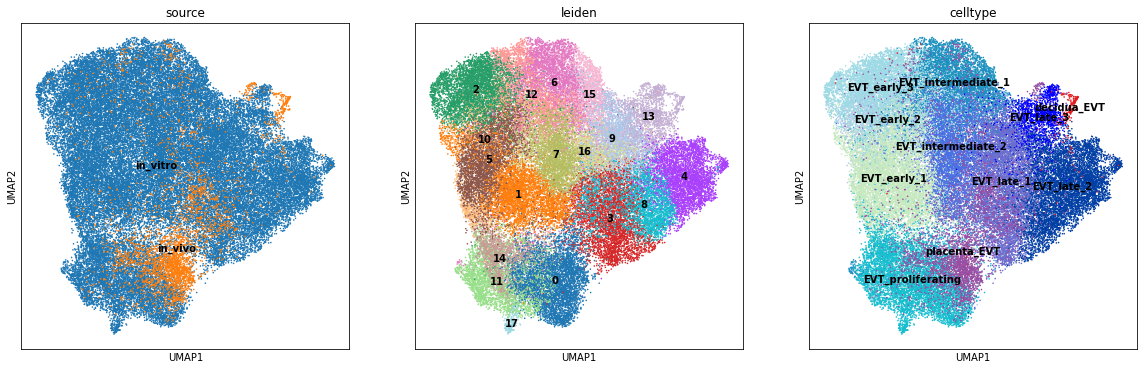

In [8]:
from matplotlib import cm, colors
cols = list(map(colors.to_hex, cm.tab20.colors))
cols2 = list(map(colors.to_hex, cm.tab20b.colors))
cols3 = list(map(colors.to_hex, cm.tab20c.colors))

lvs = ['EVT_proliferating', 'EVT_early_1', 'EVT_early_2', 'EVT_early_3',
       'EVT_intermediate_1', 'EVT_intermediate_2',
       'EVT_late_1', 'EVT_late_2', 'EVT_late_3',
       'placenta_EVT', 'decidua_EVT']
adata.obs['celltype'].cat.reorder_categories(lvs, inplace=True)
adata.uns['celltype_colors'] = ([cols[18]] + [cols3[11]] + [cols[1]] + [cols[19]] +
                                ['#1d91c0'] + ['#4a6fe3'] +
                                [cols2[2]] + ['#023fa5'] + ['#0000ff'] +
                                ['#984ea3'] + ['#e41a1c'])
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20, 6))
for i, pp in enumerate(['source', 'leiden', 'celltype']):
    sc.pl.umap(adata, color=pp, show=False, legend_loc='on data', ax=axs[i], title=pp, size=10, legend_fontsize=10)
plt.show()